In [63]:
import pandas as pd  
import numpy as np         
import seaborn as sns  
import matplotlib.pyplot as plt

import sys
sys.path.append('../models/')
from constants import COST_MODEL_PLOT_DIR

![ev](../images/adobe_stock_img_ev.jpg)


# Energy Costs: High End Brands vs. Low End Brands

Let's return to the question we formulated while exploring the EV dataset in the EV_EDA notebook. 

What are the differences in monthly energy expenses between high end and low end EVs?

In order to answer this question we will need to use both datasets to calculate intermediate values. 

Use the EV dataset from the EU we can: 
- Use the **Efficiency_WhKm** which is the rate of energy consumption per EV brand and model to help model cost
- Use **Range_kM** which is the range of the battery per EV brand and Model to help model cost as well 
- Use **PriceEuro** which is the cost of the EV to calculate a ratio between monthly energy costs and price of the EV
- Use **TopSpeed_KmH**, **TopSpeed_Kmh**, and **PriceEuro** to help distinguish between what constitutes a high end and low end EV. 

Using the EV charging dataset from the US we can:
- We can use **kwhTotal**, **dollars**, to calculate a $/kWh rate

Since we are using a dataset from the US to reverse engineer a $/kWh rate and a EU dataset attached to the euro currency for EVs, our final interpretation of the results will have to be attentive to our data sources. 

In [64]:
# load datasets 
df_ev = pd.read_csv("../data/ElectricCarData_Clean.csv")
df_charging = pd.read_csv("../data/station_data_dataverse.csv")

# strip white spaces from strings
df_ev.Brand = df_ev.Brand.apply(lambda b: b.strip())
df_ev.Model = df_ev.Model.apply(lambda m: m.strip())
df_ev.replace('-', None, inplace=True)
df_ev.dropna(inplace=True) # only 5 rows 

In [65]:
df_ev.isnull().sum()

Brand              0
Model              0
AccelSec           0
TopSpeed_KmH       0
Range_Km           0
Efficiency_WhKm    0
FastCharge_KmH     0
RapidCharge        0
PowerTrain         0
PlugType           0
BodyStyle          0
Segment            0
Seats              0
PriceEuro          0
dtype: int64

In [66]:
df_ev.head(2)

,Brand,Model,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,FastCharge_KmH,RapidCharge,PowerTrain,PlugType,BodyStyle,Segment,Seats,PriceEuro
0,Tesla,Model 3 Long Range Dual Motor,4.6,233,450,161,940,Yes,AWD,Type 2 CCS,Sedan,D,5,55480
1,Volkswagen,ID.3 Pure,10.0,160,270,167,250,Yes,RWD,Type 2 CCS,Hatchback,C,5,30000


In [67]:
df_charging.head(2) 

,sessionId,kwhTotal,dollars,created,ended,startTime,endTime,chargeTimeHrs,weekday,platform,...,managerVehicle,facilityType,Mon,Tues,Wed,Thurs,Fri,Sat,Sun,reportedZip
0,1366563,7.78,0.0,0014-11-18 15:40:26,0014-11-18 17:11:04,15,17,1.510556,Tue,android,...,0,3,0,1,0,0,0,0,0,0
1,3075723,9.74,0.0,0014-11-19 17:40:26,0014-11-19 19:51:04,17,19,2.177222,Wed,android,...,0,3,0,0,1,0,0,0,0,0


In [68]:
df_ev.describe()

,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,Seats,PriceEuro
count,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000
mean,7.046939,181.653061,350.153061,189.867347,4.959184,57324.683673
std,2.483895,43.248527,118.217984,30.055837,0.687418,34288.246370
min,2.100000,123.000000,170.000000,104.000000,4.000000,20129.000000
25%,5.100000,150.000000,258.750000,168.000000,5.000000,35000.000000
50%,7.300000,167.000000,350.000000,181.000000,5.000000,45000.000000
75%,8.950000,200.000000,407.500000,206.000000,5.000000,65465.000000
max,14.000000,410.000000,970.000000,273.000000,7.000000,215000.000000


In [69]:
df_ev = df_ev.drop_duplicates(['Brand', 'Model'])# there's only 1 dup

In [70]:
# Lightyear is a solar EV which will not need to use charging stations 
df_ev = df_ev[df_ev.Brand !='Lightyear']

/var/folders/_b/bg10lw5s3qv87q59tkf0hsrc0000gn/T/ipykernel_12855/4067227100.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rate_charge['dollar_per_kWh'] = dollars/kwh_sum


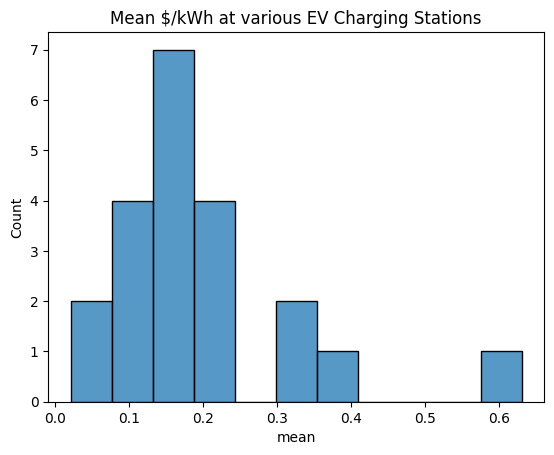

In [71]:
# drop rows with $0 and 0 kWh
mask1 = df_charging.dollars>0.0
mask2 = df_charging.kwhTotal>0.0
df_rate_charge = df_charging[mask1 & mask2]

dollars = df_rate_charge.dollars
kwh_sum = df_rate_charge.kwhTotal

df_rate_charge['dollar_per_kWh'] = dollars/kwh_sum

# this is the distribution of the mean $/kWh at every charging location 
mean_rates = df_rate_charge.groupby('locationId')['dollar_per_kWh'].describe()['mean']
sns.histplot(mean_rates, kde=False)
# Set title
plt.title('Mean $/kWh at various EV Charging Stations')
plt.savefig(COST_MODEL_PLOT_DIR + 'Mean_rate_at_various_EV_Charging_Stations.png')
plt.show()

In [72]:
# the mean dollar per kWh rate at various charging locations 
# we want to take a weighted mean of means to get an overall mean calc of dollar_per_kWh
# because the locations have unequal sample sizes, we must calc location weights 
df_rate_charge.groupby('locationId')['dollar_per_kWh'].describe()

,count,mean,std,min,25%,50%,75%,max
locationId,,,,,,,,
125372,7.0,0.090240,0.040240,0.068213,0.074447,0.076453,0.078502,0.181115
144857,13.0,0.120642,0.088811,0.069638,0.078616,0.096961,0.114173,0.401544
202527,10.0,0.146332,0.175904,0.071942,0.075798,0.088617,0.112331,0.644315
399399,6.0,0.200767,0.122924,0.075758,0.092382,0.185575,0.298588,0.360119
461655,55.0,0.194181,0.152699,0.065445,0.092583,0.120116,0.227825,0.716495
481066,14.0,0.137639,0.126526,0.072254,0.077280,0.087373,0.155000,0.557880
493904,19.0,0.163356,0.161936,0.072150,0.074854,0.083815,0.164495,0.698529
503205,20.0,0.344435,0.331342,0.070225,0.099594,0.208363,0.446220,1.063830
517854,14.0,0.056840,0.048448,0.024534,0.032822,0.037815,0.063843,0.205072


In [73]:
# the weight mean of means for unequal sample sizes between the individual means provided in table 
def calc_weight_means_of_mean(df):
    # sample counts 
    location_counts = df.groupby('locationId')['dollar_per_kWh'].describe()['count']

    # total number of samples 
    total_samples = location_counts.sum()

    # weights = sample_counts / total_samples
    weights = location_counts/total_samples

    # means from each location 
    means = df.groupby('locationId')['dollar_per_kWh'].describe()['mean'] 

    # take sum of products between weights and means from each location 
    return sum(weights * means)

dollar_per_kWh = calc_weight_means_of_mean(df_rate_charge)
dollar_per_kWh # [$/kWh]

0.1939790894347337

In [74]:
# the unweighted mean of means isn't very far off 
df_rate_charge.groupby('locationId')['dollar_per_kWh'].describe()['mean'].mean()

0.1898562227299036

## Create High and Low Tier Labels using Clustering 

We are creating the Tier feature in terms of EV performance metrics and not on price clustering analysis.

A top tier EV will have outstanding performance metrics and low tier EV will have lower end performance metrics, a simple direct relationship. 
We can compare the resulting tier labels with the price of the EV later in our analysis. 


Silhouette Score: 0.4574759506067729
Davies-Bouldin Index: 0.7666439800932786


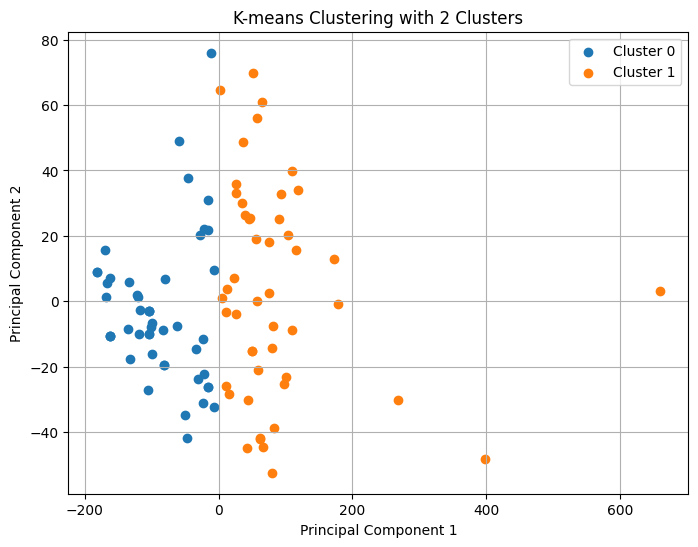

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score

# do not include PriceEuro for clustering, it leads to nonsensical results in the distributions 
performance_feats = ['AccelSec', 'TopSpeed_KmH', 'Range_Km', 'Efficiency_WhKm']


# of the performance features 
# Step 1: Perform k-means clustering
K = 2
kmeans = KMeans(n_clusters=K, random_state=1234)  # Set the number of clusters to 3
cluster_labels = kmeans.fit_predict(df_ev[performance_feats])

# Step 2: Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_ev[performance_feats])

# Step 3: Create a new DataFrame with the principal components and cluster labels
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
principal_df['Cluster'] = cluster_labels
df_ev['Cluster'] = cluster_labels

# Step 4: Plot the results
plt.figure(figsize=(8, 6))
for cluster in range(K):  # Iterate over each cluster
    cluster_data = principal_df[principal_df['Cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'K-means Clustering with {K} Clusters')

# Step 5: Calculate and print silhouette score
silhouette = silhouette_score(df_ev[performance_feats], cluster_labels)
print(f"Silhouette Score: {silhouette}")

# Step 6: Calculate and print Davies-Bouldin index
davies_bouldin = davies_bouldin_score(df_ev[performance_feats], cluster_labels)
print(f"Davies-Bouldin Index: {davies_bouldin}")

plt.legend()
plt.grid(True)
plt.savefig(COST_MODEL_PLOT_DIR + f'K-means Clustering with {K} Clusters.png')
plt.show()


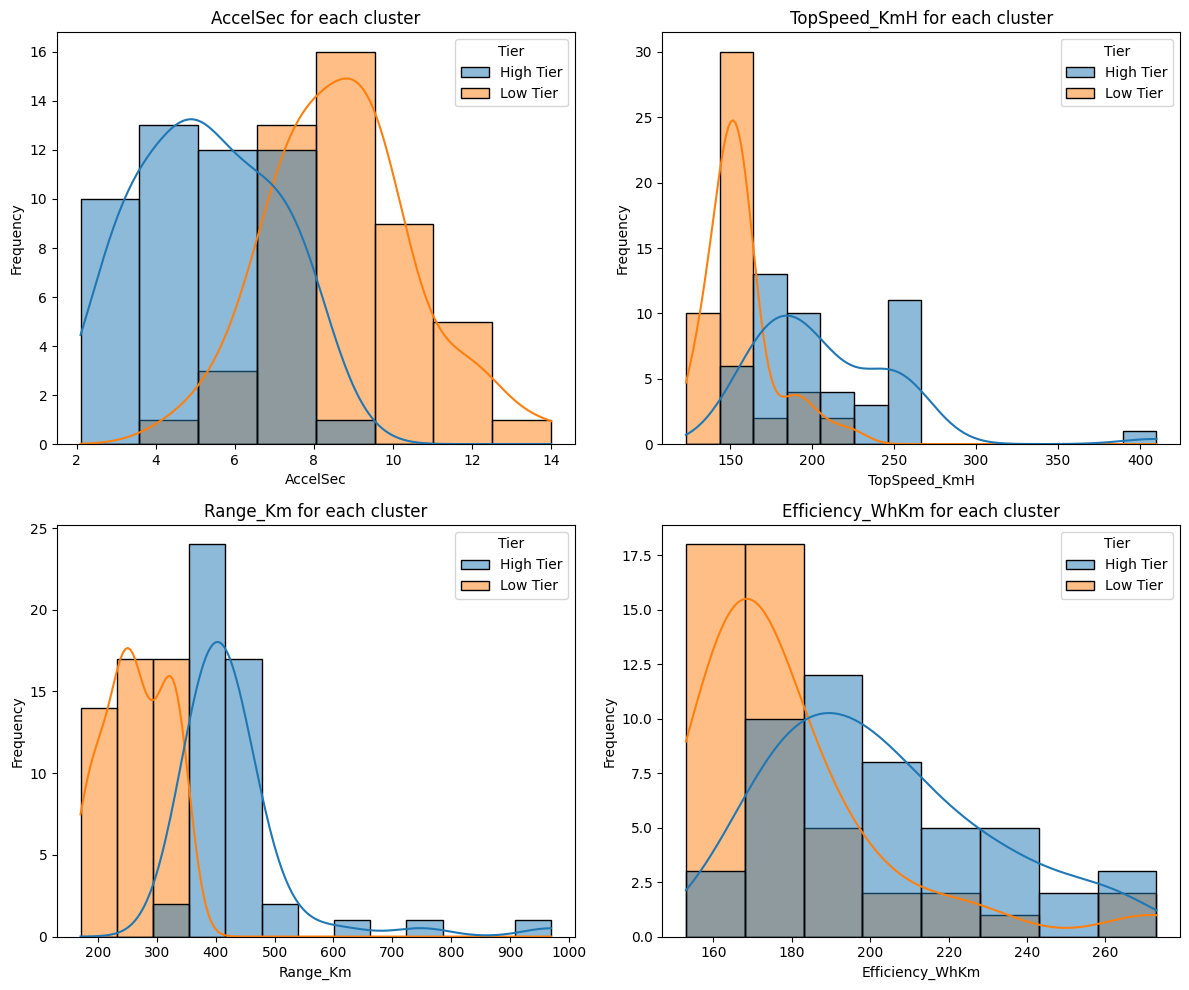

In [76]:
# Let's plot our EV tiers and make sure they make sense
performance_feats = ['AccelSec', 'TopSpeed_KmH', 'Range_Km', 'Efficiency_WhKm']
df_ev['Tier'] = df_ev.Cluster.replace([0,1], ['Low Tier', 'High Tier'])

# Create a 2 by 2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over each feature in x_feats and plot histograms
for i, col in enumerate(performance_feats):
    sns.histplot(data=df_ev, x=col, hue='Tier', kde=True, ax=axes[i])
    axes[i].set_title('{} for each cluster'.format(col))
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Adjust layout and show the plots
plt.tight_layout()
plt.savefig(COST_MODEL_PLOT_DIR + f'performance_metrics_by_tier.png')
plt.show()


The distributions of the four performance metrics show that there are 2 somewhat distinct distributions among EVs however there is a considerable amount of overlap, especially with the energy efficiency metrics. If we swap cluster labels 0 and 1 for High Tier and Low Tier respectively, we see that distributions are consistent with what we would expect to see between high and low tier EVs. It actually unsurprising to see some overlap between distributions since there really isn't an objective threshold for what is considered low and high tier EVs, instead what we see is continuous spectrum of increasing performance with car models.



In [77]:
df_ev.groupby(['Tier'])[performance_feats].describe().T

Tier                    High Tier    Low Tier
AccelSec        count   48.000000   48.000000
                mean     5.285417    8.729167
                std      1.730821    1.864787
                min      2.100000    4.500000
                25%      3.950000    7.300000
                50%      5.100000    8.850000
                75%      6.650000    9.725000
                max      8.800000   14.000000
TopSpeed_KmH    count   48.000000   48.000000
                mean   208.208333  156.062500
                std     44.990287   20.524408
                min    160.000000  123.000000
                25%    180.000000  145.000000
                50%    200.000000  150.000000
                75%    243.250000  160.000000
                max    410.000000  225.000000
Range_Km        count   48.000000   48.000000
                mean   430.000000  265.312500
                std    104.820008   53.974051
                min    335.000000  170.000000
                25%    375.000000  228.750000
                50%    405.000000  255.000000
                75%    440.000000  320.000000
                max    970.000000  350.000000
Efficiency_WhKm count   48.000000   48.000000
                mean   202.395833  179.437500
                std     27.386702   26.102830
                min    160.000000  153.000000
                25%    181.000000  165.750000
                50%    197.000000  169.000000
                75%    216.250000  182.750000
                max    267.000000  273.000000

In [78]:
# these first two tables sort EVs by the performance metrics that directly correlate to price 
df_ev[df_ev.Cluster==0].sort_values(['PriceEuro', 'TopSpeed_KmH', 'Range_Km', 'Efficiency_WhKm'], ascending=False).head(10)

,Brand,Model,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,FastCharge_KmH,RapidCharge,PowerTrain,PlugType,BodyStyle,Segment,Seats,PriceEuro,Cluster,Tier
90,Audi,e-tron S 55 quattro,4.5,210,320,270,510,Yes,AWD,Type 2 CCS,SUV,E,5,93800,0,Low Tier
84,Mercedes,EQV 300 Long,10.0,140,330,273,290,Yes,FWD,Type 2 CCS,SPV,N,7,70631,0,Low Tier
87,Audi,e-tron Sportback 50 quattro,6.8,190,295,219,470,Yes,AWD,Type 2 CCS,SUV,E,5,69551,0,Low Tier
30,Audi,e-tron 50 quattro,6.8,190,280,231,450,Yes,AWD,Type 2 CCS,SUV,E,5,67358,0,Low Tier
78,Ford,Mustang Mach-E SR AWD,6.0,180,340,206,360,Yes,AWD,Type 2 CCS,SUV,D,5,54000,0,Low Tier
97,Byton,M-Byte 72 kWh 2WD,7.5,190,325,222,420,Yes,RWD,Type 2 CCS,SUV,E,5,53500,0,Low Tier
100,Nissan,Ariya e-4ORCE 63kWh,5.9,200,325,194,440,Yes,AWD,Type 2 CCS,Hatchback,C,5,50000,0,Low Tier
36,Lexus,UX 300e,7.5,160,270,193,190,Yes,FWD,Type 2 CHAdeMO,SUV,C,5,50000,0,Low Tier
8,Tesla,Model 3 Standard Range Plus,5.6,225,310,153,650,Yes,RWD,Type 2 CCS,Sedan,D,5,46380,0,Low Tier
98,Nissan,Ariya 63kWh,7.5,160,330,191,440,Yes,FWD,Type 2 CCS,Hatchback,C,5,45000,0,Low Tier


In [79]:
df_ev[df_ev.Cluster==1].sort_values(['PriceEuro', 'TopSpeed_KmH', 'Range_Km', 'Efficiency_WhKm'], ascending=False).head(10)

,Brand,Model,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,FastCharge_KmH,RapidCharge,PowerTrain,PlugType,BodyStyle,Segment,Seats,PriceEuro,Cluster,Tier
51,Tesla,Roadster,2.1,410,970,206,920,Yes,AWD,Type 2 CCS,Cabrio,S,4,215000,1,High Tier
16,Porsche,Taycan Turbo S,2.8,260,375,223,780,Yes,AWD,Type 2 CCS,Sedan,F,4,180781,1,High Tier
72,Porsche,Taycan Cross Turismo,3.5,250,385,217,770,Yes,AWD,Type 2 CCS,Station,F,4,150000,1,High Tier
79,Porsche,Taycan Turbo,3.2,260,390,215,810,Yes,AWD,Type 2 CCS,Sedan,F,4,148301,1,High Tier
23,Audi,e-tron GT,3.5,240,425,197,850,Yes,AWD,Type 2 CCS,Sedan,F,4,125000,1,High Tier
65,Porsche,Taycan 4S Plus,4.0,250,425,197,890,Yes,AWD,Type 2 CCS,Sedan,F,4,109302,1,High Tier
5,Lucid,Air,2.8,250,610,180,620,Yes,AWD,Type 2 CCS,Sedan,F,5,105000,1,High Tier
81,Tesla,Model X Performance,2.8,250,440,216,480,Yes,AWD,Type 2,SUV,F,7,102990,1,High Tier
47,Porsche,Taycan 4S,4.0,250,365,195,730,Yes,AWD,Type 2 CCS,Sedan,F,4,102945,1,High Tier
59,Tesla,Model S Performance,2.5,261,505,188,550,Yes,AWD,Type 2,Liftback,F,5,96990,1,High Tier


In [80]:
# these last two tables sort EVs by the performance metric AccelSec that indirectly correlates to price 
df_ev[df_ev.Cluster==0].sort_values(['AccelSec']).head(10)

,Brand,Model,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,FastCharge_KmH,RapidCharge,PowerTrain,PlugType,BodyStyle,Segment,Seats,PriceEuro,Cluster,Tier
90,Audi,e-tron S 55 quattro,4.5,210,320,270,510,Yes,AWD,Type 2 CCS,SUV,E,5,93800,0,Low Tier
8,Tesla,Model 3 Standard Range Plus,5.6,225,310,153,650,Yes,RWD,Type 2 CCS,Sedan,D,5,46380,0,Low Tier
100,Nissan,Ariya e-4ORCE 63kWh,5.9,200,325,194,440,Yes,AWD,Type 2 CCS,Hatchback,C,5,50000,0,Low Tier
78,Ford,Mustang Mach-E SR AWD,6.0,180,340,206,360,Yes,AWD,Type 2 CCS,SUV,D,5,54000,0,Low Tier
87,Audi,e-tron Sportback 50 quattro,6.8,190,295,219,470,Yes,AWD,Type 2 CCS,SUV,E,5,69551,0,Low Tier
30,Audi,e-tron 50 quattro,6.8,190,280,231,450,Yes,AWD,Type 2 CCS,SUV,E,5,67358,0,Low Tier
70,BMW,i3s 120 Ah,6.9,160,230,165,260,Yes,RWD,Type 2 CCS,Hatchback,B,4,41526,0,Low Tier
80,Volkswagen,ID.3 1st,7.3,160,340,171,470,Yes,RWD,Type 2 CCS,Hatchback,C,5,38987,0,Low Tier
46,Opel,Ampera-e,7.3,150,335,173,210,Yes,FWD,Type 2 CCS,MPV,B,5,41906,0,Low Tier
19,Mini,Cooper SE,7.3,150,185,156,260,Yes,FWD,Type 2 CCS,Hatchback,B,4,31681,0,Low Tier


In [81]:
df_ev[df_ev.Cluster==1].sort_values(['AccelSec']).head(10)

,Brand,Model,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,FastCharge_KmH,RapidCharge,PowerTrain,PlugType,BodyStyle,Segment,Seats,PriceEuro,Cluster,Tier
51,Tesla,Roadster,2.1,410,970,206,920,Yes,AWD,Type 2 CCS,Cabrio,S,4,215000,1,High Tier
59,Tesla,Model S Performance,2.5,261,505,188,550,Yes,AWD,Type 2,Liftback,F,5,96990,1,High Tier
5,Lucid,Air,2.8,250,610,180,620,Yes,AWD,Type 2 CCS,Sedan,F,5,105000,1,High Tier
81,Tesla,Model X Performance,2.8,250,440,216,480,Yes,AWD,Type 2,SUV,F,7,102990,1,High Tier
16,Porsche,Taycan Turbo S,2.8,260,375,223,780,Yes,AWD,Type 2 CCS,Sedan,F,4,180781,1,High Tier
33,Tesla,Cybertruck Tri Motor,3.0,210,750,267,710,Yes,AWD,Type 2 CCS,Pickup,N,6,75000,1,High Tier
79,Porsche,Taycan Turbo,3.2,260,390,215,810,Yes,AWD,Type 2 CCS,Sedan,F,4,148301,1,High Tier
24,Tesla,Model 3 Long Range Performance,3.4,261,435,167,910,Yes,AWD,Type 2 CCS,Sedan,D,5,61480,1,High Tier
23,Audi,e-tron GT,3.5,240,425,197,850,Yes,AWD,Type 2 CCS,Sedan,F,4,125000,1,High Tier
72,Porsche,Taycan Cross Turismo,3.5,250,385,217,770,Yes,AWD,Type 2 CCS,Station,F,4,150000,1,High Tier


## Calculate Energy consumption cost of of EVs. 

Now that we have calculated an average $/kWh rate and the tier groups, we can calculate the monthly, annual, and 10-year energy consumption cost for each model and a distribution for each Brand. 

We can do this by

- Using the **Efficiency_WhKm** which is the rate of energy consumption per EV brand and model to help model cost
- Using **Range_kM** which is the range of the battery per EV Model to help model cost as well 
- Using the mean of means $/kWh rate to get a cost for energy consumption 
- **ASSUMING** the same distance traveled for each EV model every month 

The assumption maybe not actually directly map to any individual EV driver's time spent driving however it is a constant value we will use to be able to compare between different EVs and that cost comparison is the really value of this analysis. 

### Distance Driven Each Month Assumption 

Let's assume that a typical city commuter with a 9-to-5 job drives 800 Km a month, which comes equates to about 500 miles a month. 

The formulate we will use to calculate the energy cost consumption of each EV: 

$$\text{Charge Rate x Distance Traveled x 1/Efficiency = Cost}$$

Where $\text{Charge Rate}$ is the $/kWh for charging an EV

Where $\text{Distance Traveled }$ is 800 Km 

Where $\text{Efficiency}$ is EV efficiency of converting energy into distance traveled Wh/Km. We need to convert Wh into kWh for conversion to work out. 

And $\text{Cost}$ is the number of dollars paid to the charing station. 

In [82]:
def calc_monthly_EV_energy_cost(df):
    MONTHLY_DIST_TRAVELED = 800 # Km 
    eff_kWh_per_Km = df.Efficiency_WhKm/1000 # convert Wh/Km -> kWh/Km
    return dollar_per_kWh * MONTHLY_DIST_TRAVELED * (eff_kWh_per_Km)  # $/month

In [83]:
df_ev['monthly_energy_cost'] = calc_monthly_EV_energy_cost(df_ev)
df_ev['annual_energy_cost'] = calc_monthly_EV_energy_cost(df_ev) * 12
df_ev['ten_year_energy_cost'] = calc_monthly_EV_energy_cost(df_ev) * 12 * 10

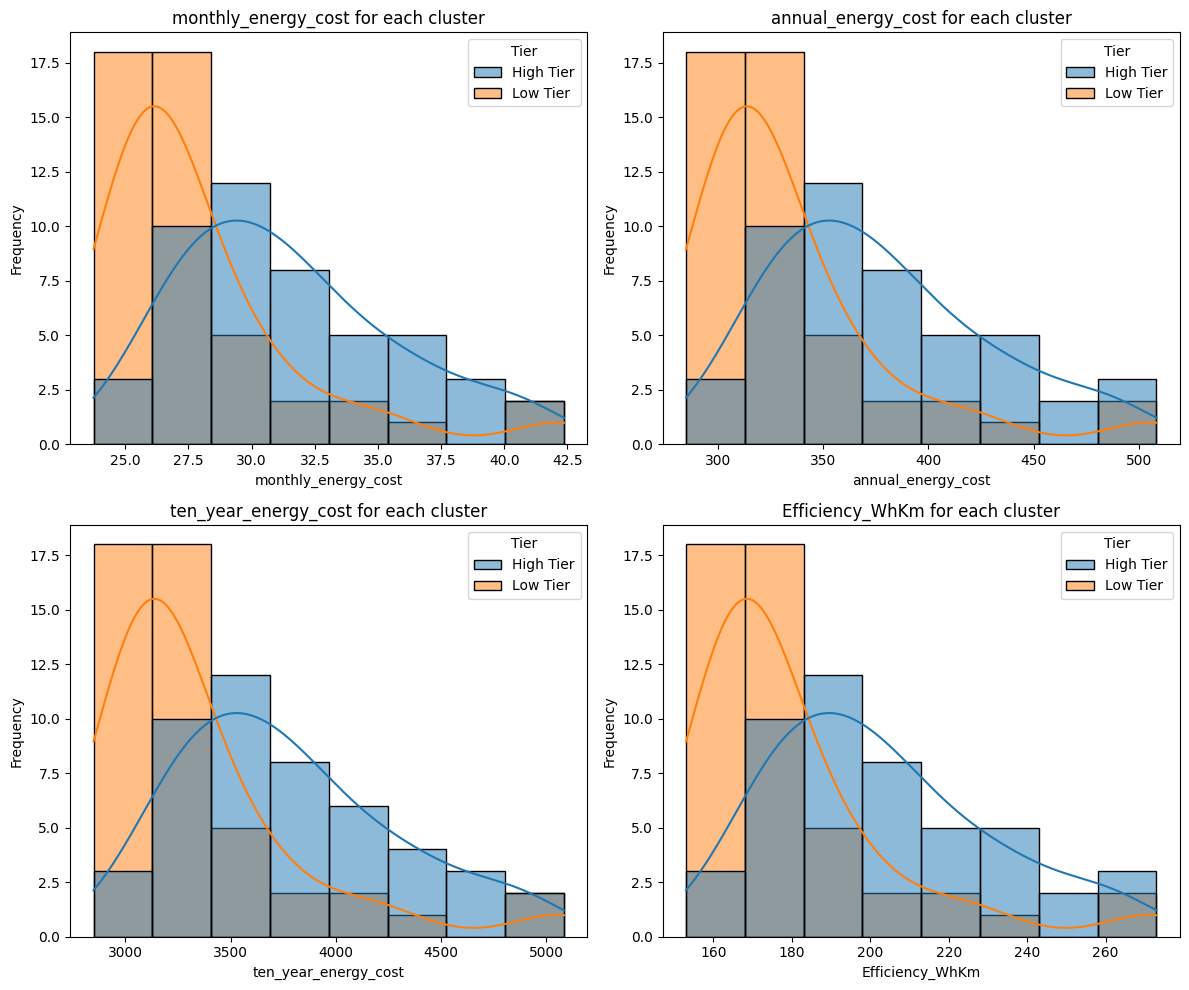

In [84]:
# Let's plot our EV tiers and make sure they make sense
cost_feats = ['monthly_energy_cost', 'annual_energy_cost', 'ten_year_energy_cost', 'Efficiency_WhKm']

# Create a 2 by 2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over each feature in x_feats and plot histograms
for i, col in enumerate(cost_feats):
    sns.histplot(data=df_ev, x=col, hue='Tier', kde=True, ax=axes[i])
    axes[i].set_title('{} for each cluster'.format(col))
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Adjust layout and show the plots
plt.tight_layout()
plt.savefig(COST_MODEL_PLOT_DIR + f'EV_energy_cost_by_timeframes_by_tier.png')
plt.show()

Recall that Efficiency Wh/Km means that the EV will consume a certain amount of energy to travel a certain amount of Km. The High Tier EVs have a high Efficiency score meaning that they will consume more energy to travel the same distance as the Low Tier EVs, this might be because more energy consumption is required to faster acceleration to higher top speeds; higher performance requires more energy. 

In [85]:
df_ev.groupby(['Tier'])[cost_feats].describe().T

Tier                          High Tier     Low Tier
monthly_energy_cost  count    48.000000    48.000000
                     mean     31.408448    27.845698
                     std       4.249958     4.050722
                     min      24.829323    23.743041
                     25%      28.088172    25.721627
                     50%      30.571104    26.225973
                     75%      33.558382    28.359743
                     max      41.433934    42.365033
annual_energy_cost   count    48.000000    48.000000
                     mean    376.901371   334.148379
                     std      50.999497    48.608670
                     min     297.951881   284.916487
                     25%     337.058066   308.659527
                     50%     366.853254   314.711675
                     75%     402.700590   340.316915
                     max     497.207202   508.380398
ten_year_energy_cost count    48.000000    48.000000
                     mean   3769.013708  3341.483795
                     std     509.994970   486.086699
                     min    2979.518814  2849.164866
                     25%    3370.580658  3086.595271
                     50%    3668.532539  3147.116747
                     75%    4027.005897  3403.169145
                     max    4972.072020  5083.803976
Efficiency_WhKm      count    48.000000    48.000000
                     mean    202.395833   179.437500
                     std      27.386702    26.102830
                     min     160.000000   153.000000
                     25%     181.000000   165.750000
                     50%     197.000000   169.000000
                     75%     216.250000   182.750000
                     max     267.000000   273.000000

In [86]:
import numpy as np
from scipy import stats

# Generate two random distributions
np.random.seed(0)
dist1 = df_ev[df_ev.Tier == 'Low Tier']['monthly_energy_cost']
dist2 = df_ev[df_ev.Tier == 'High Tier']['monthly_energy_cost']

t_stat, p_value = stats.ttest_ind(dist1, dist2)
print("T-test - t-statistic:", t_stat, "p-value:", p_value)

T-test - t-statistic: -4.20418782456666 p-value: 5.972025076929644e-05


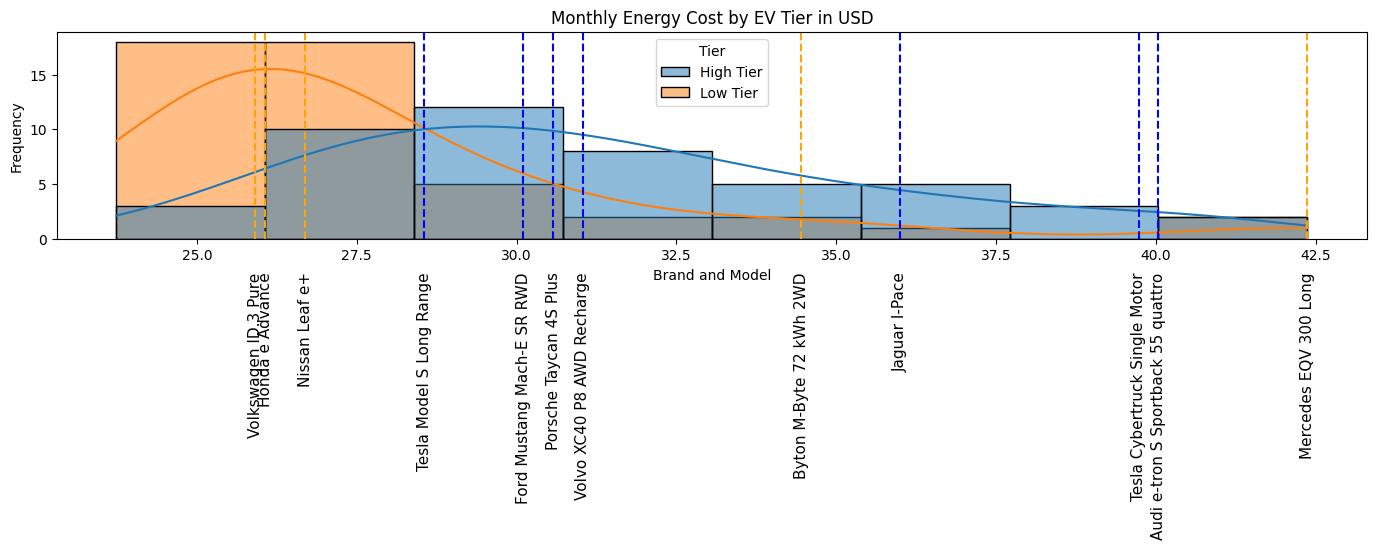

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np



# Randomly sample 10 Brand and Model string values
sampled_cars = df_ev.sample(n=12, random_state=1234)
sampled_cars['Brand_Model'] = sampled_cars['Brand'] + ' ' + sampled_cars['Model']

# Plotting
plt.figure(figsize=(14, 6))

# Plot the distribution
sns.histplot(data=df_ev, x='monthly_energy_cost', kde=True, hue='Tier')

# Plot vertical lines for each sampled car's monthly_energy_cost
for index, row in sampled_cars.iterrows():
    color = 'blue' if row['Tier'] == 'High Tier' else 'orange'
    plt.axvline(x=row['monthly_energy_cost'], color=color, linestyle='--')
    plt.text(row['monthly_energy_cost'], -3.0, row['Brand_Model'], rotation=90, ha='center', va='top', fontsize=11)

# Set x-axis ticks and labels for Brand and Model
#plt.xticks(sampled_cars['monthly_energy_cost'], sampled_cars['Brand_Model'], rotation=90)

# Set additional x-axis ticks and labels for monthly_energy_cost
plt.gca().set_xticks([25, 30, 40, 42.5], minor=True)
plt.gca().set_xticklabels([25, 30, 40, 42.5], minor=True)

# Set title and labels
plt.title('Monthly Energy Cost by EV Tier in USD')
plt.xlabel('Brand and Model')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig(COST_MODEL_PLOT_DIR + 'Monthly Energy Cost by EV Tier.png')
plt.show()

In [88]:
feats = ["Brand", "Model", "AccelSec", "TopSpeed_KmH", "Range_Km", "Efficiency_WhKm","PriceEuro", 'monthly_energy_cost', 'Tier']
sampled_cars[feats].sort_values(["TopSpeed_KmH"], ascending=False)

,Brand,Model,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,PriceEuro,monthly_energy_cost,Tier
40,Tesla,Model S Long Range,3.8,250,515,184,79990,28.553722,High Tier
65,Porsche,Taycan 4S Plus,4.0,250,425,197,109302,30.571104,High Tier
99,Audi,e-tron S Sportback 55 quattro,4.5,210,335,258,96050,40.037284,High Tier
63,Jaguar,I-Pace,4.8,200,365,232,75351,36.002519,High Tier
97,Byton,M-Byte 72 kWh 2WD,7.5,190,325,222,53500,34.450686,Low Tier
83,Ford,Mustang Mach-E SR RWD,6.6,180,360,194,46900,30.105555,High Tier
86,Tesla,Cybertruck Single Motor,7.0,180,390,256,45000,39.726918,High Tier
27,Volvo,XC40 P8 AWD Recharge,4.9,180,375,200,60437,31.036654,High Tier
1,Volkswagen,ID.3 Pure,10.0,160,270,167,30000,25.915606,Low Tier
35,Nissan,Leaf e+,7.3,157,325,172,37237,26.691523,Low Tier


The above plot shows the distribution of the monthly energy costs for each tier. 

The table provides the performance metrics, monthly energy cost, and the price of the EV in euros, and the tier label from clustering. 

Recall from the regression models that **TopSpeed_KmH** and **AccelSec** where the most predictive of price, so the cluster results are consistent with the pricing of the EVs (if we assume that price alone is a good proxy for distinguishing between high and low tier EVs). Recall that we are defining Tier in terms of EV performance metrics and not on EV price tag in our clustering analysis. 

Of the 12 randomly sampled EVs, we see that the tier labels to make sense. The Byton M-Byte 72 kWh 2WD is classified as low tier in the middle of the high tier EVs, when ordered by AccelSec.  Perhaps this is because it's acceleration and energy efficiency is on the lower end of the distribution.  
